# **Final Project Task 3 - Census Modeling Regression**

Requirements
- Create a regression model on the Census dataset, with 'hours-per-week' target

- You can use models (estmators) from sklearn, but feel free to use any library for traditional ML. 
    - Note: in sklearn, the LinearRegression estimator is based on OLS, a statistical method. Please use the SGDRegressor estimator, since this is based on gradient descent. 
    - You can use LinearRegression estimator, but only as comparison with the SGDRegressor - Optional.

- Model Selection and Setup **2p**:
    - Implement multiple models, to solve a regression problem using traditional ML: 
        - Linear Regression
        - Decision Tree Regression
        - Random Forest Regression - Optional
        - Ridge Regression - Optional
        - Lasso Regression - Optional
    - Choose a loss (or experiment with different losses) for the model and justify the choice. *1p*
        - MSE, MAE, RMSE, Huber Loss or others
    - Justify model choices based on dataset characteristics and task requirements; specify model pros and cons. *1p*


- Data Preparation
    - Use the preprocessed datasets from Task 1.
    - From the train set, create an extra validation set, if necesarry. So in total there will be: train, validation and test datasets.
    - Be sure all models have their data preprocessed as needed. Some models require different, or no encoding for some features.


- Model Training and Experimentation **10p**
    - Establish a Baseline Model *2p*
        - For each model type, train a simple model with default settings as a baseline.
        - Evaluate its performance to establish a benchmark for comparison.
    - Make plots with train, validation loss and metric on epochs (or on steps), if applicable. - Optional
    - Feature Selection: - Optional
        - Use insights from EDA in Task 2 to identify candidate features by analyzing patterns, relationships, and distributions.
    - Experimentation: *8p*
        - For each baseline model type, iteratively experiment with different combinations of features and transformations.
        - Experiment with feature engineering techniques such as interaction terms, polynomial features, or scaling transformations.
        - Identify the best model which have the best performance metrics on test set.
        - You may need multiple preprocessed datasets preprocessed
- Hyperparameter Tuning - Optional
  - Perform hyperparameter tuning only on the best-performing model after evaluating all model types and experiments. 
  - Consider using techniques like Grid Search for exhaustive tuning, Random Search for quicker exploration, or Bayesian Optimization for an intelligent, efficient search of hyperparameters.
  - Avoid tuning models that do not show strong baseline performance or are unlikely to outperform others based on experimentation.
  - Ensure that hyperparameter tuning is done after completing feature selection, baseline modeling, and experimentation, ensuring that the model is stable and representative of the dataset.


- Model Evaluation **3p**
    - Evaluate models on the test dataset using regression metrics: *1p*
        - Mean Absolute Error (MAE)
        - Mean Squared Error (MSE)
        - Root Mean Squared Error (RMSE)
        - R² Score
    - Choose one metric for model comparison and explain your choice *1p*
    - Compare the results across different models. Save all experiment results  into a table. *1p*

Feature Importance - Optional
- For applicable models (e.g., Decision Tree Regression), analyze feature importance and discuss its relevance to the problem.



Deliverables

- Notebook code with no errors.
- Code and results from experiments. Create a table with all experiments results, include experiment name, metrics results.
- Explain findings, choices, results.
- Potential areas for improvement or further exploration.


## 1. Import date

In [1]:
import pandas as pd

train_df = pd.read_csv("preprocessed_train_task1.csv")
test_df = pd.read_csv("preprocessed_test_task1.csv")

X_train = train_df.drop(columns=["hours-per-week"])
y_train = train_df["hours-per-week"]

X_test = test_df.drop(columns=["hours-per-week"])
y_test = test_df["hours-per-week"]

X_train.shape, X_test.shape

((26029, 110), (6508, 110))

## 2. Set de validare
Din setul de antrenare a fost creat un set de validare pentru compararea modelelor și evitarea supraînvățării.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

## 3. Metrici de evaluare
Pentru evaluarea performanței modelelor sunt utilizate MAE, MSE, RMSE și R².


In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_regression(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }


## 4. Baseline models

### SGDRegressor


In [14]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(
    random_state=42,
    max_iter=2000,
    tol=1e-3
)

sgd.fit(X_train, y_train)

sgd_val_pred = sgd.predict(X_val)
sgd_metrics = evaluate_regression(y_val, sgd_val_pred)

sgd_metrics


{'MAE': 4.4111571124943945,
 'MSE': 30.784625951270463,
 'RMSE': np.float64(5.548389491669674),
 'R2': 0.19092880607049578}

**Interpretare**

SGDRegressor obține un MAE de aproximativ 4.4 ore și un scor R² ≈ 0.19, indicând o capacitate limitată de a explica variabilitatea targetului

### Linear Regression

In [15]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

lr_val_pred = lr.predict(X_val)
lr_metrics = evaluate_regression(y_val, lr_val_pred)

lr_metrics

{'MAE': 4.406963764473326,
 'MSE': 30.58411196219373,
 'RMSE': np.float64(5.530290404869687),
 'R2': 0.19619864734771897}

**Interpretare**

Performanța modelului Linear Regression este foarte similară cu cea a SGDRegressor, cu valori apropiate pentru MAE, RMSE și R². Acest rezultat confirmă faptul că relațiile dintre variabilele explicative și țintă sunt în mare parte liniare slabe și că optimizarea prin gradient descent nu aduce îmbunătățiri semnificative în acest caz față de soluția OLS clasică.


### Loss Function Selection for SGDRegressor


In [16]:
import pandas as pd
from sklearn.linear_model import SGDRegressor

losses = ["squared_error", "huber", "epsilon_insensitive"]
loss_results = []

for loss in losses:
    model = SGDRegressor(loss=loss, max_iter=2000, tol=1e-3, random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    m = evaluate_regression(y_val, pred)
    loss_results.append({"Experiment": f"SGD_loss={loss}", **m})

loss_df = pd.DataFrame(loss_results).sort_values(by="MAE")
loss_df

,Experiment,MAE,MSE,RMSE,R2
2,SGD_loss=epsilon_insensitive,4.290617,33.128529,5.755739,0.129327
0,SGD_loss=squared_error,4.411157,30.784626,5.548389,0.190929
1,SGD_loss=huber,5.133614,43.150623,6.568913,-0.134070


Dintre funcțiile de pierdere testate pentru SGDRegressor, loss-ul cu cel mai mic MAE pe setul de validare a fost selectat pentru comparațiile ulterioare. MAE a fost utilizată ca metrică principală deoarece este ușor de interpretat în unități reale (ore/săptămână) și mai robustă la valori extreme decât RMSE.

## 5. Modele suplimentare

### Decision Tree Regressor

In [6]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

dt_val_pred = dt.predict(X_val)
dt_metrics = evaluate_regression(y_val, dt_val_pred)

dt_metrics


{'MAE': 5.326114099116404,
 'MSE': 56.891843545908564,
 'RMSE': np.float64(7.542668198052236),
 'R2': -0.4952123132955979}

**Interpretare**

Decision Tree Regressor obține un MAE de aproximativ 5.33 ore și un scor R² ≈ −0.50, indicând o performanță slabă pe setul de validare. Rezultatele sugerează overfitting și o capacitate redusă de generalizare în lipsa regularizării arborelui.

### Random Forest Regressor

In [7]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
rf_val_pred = rf.predict(X_val)
rf_metrics = evaluate_regression(y_val, rf_val_pred)

rf_metrics


{'MAE': 4.327192353602985,
 'MSE': 30.89899552186876,
 'RMSE': np.float64(5.5586864924970145),
 'R2': 0.1879229834504763}

**Interpretare**

Random Forest Regressor obține un MAE de aproximativ 4.33 ore și un scor R² ≈ 0.19, performanță comparabilă cu modelele liniare. Deși ansamblul reduce overfitting-ul față de un arbore individual, îmbunătățirea globală rămâne limitată.

### Ridge Regression

In [17]:
from sklearn.linear_model import Ridge

ridge = Ridge(random_state=42)
ridge.fit(X_train, y_train)

ridge_val_pred = ridge.predict(X_val)
ridge_metrics = evaluate_regression(y_val, ridge_val_pred)

ridge_metrics

{'MAE': 4.416663167599171,
 'MSE': 30.633043642668436,
 'RMSE': np.float64(5.534712607052731),
 'R2': 0.19491264136520958}

### Lasso Regression

In [18]:
from sklearn.linear_model import Lasso

lasso = Lasso(random_state=42, max_iter=5000)
lasso.fit(X_train, y_train)

lasso_val_pred = lasso.predict(X_val)
lasso_metrics = evaluate_regression(y_val, lasso_val_pred)

lasso_metrics


{'MAE': 4.7584326388205325,
 'MSE': 37.7962749782273,
 'RMSE': np.float64(6.147867514693798),
 'R2': 0.006651002642434345}

## 6. Compararea modelelor

In [19]:
results = pd.DataFrame([
    {"Model": "SGDRegressor", **sgd_metrics},
    {"Model": "LinearRegression", **lr_metrics},
    {"Model": "DecisionTree", **dt_metrics},
    {"Model": "RandomForest", **rf_metrics},
    {"Model": "Ridge", **ridge_metrics},
    {"Model": "Lasso", **lasso_metrics},
])

results

,Model,MAE,MSE,RMSE,R2
0,SGDRegressor,4.411157,30.784626,5.548389,0.190929
1,LinearRegression,4.406964,30.584112,5.530290,0.196199
2,DecisionTree,5.326114,56.891844,7.542668,-0.495212
3,RandomForest,4.327192,30.898996,5.558686,0.187923
4,Ridge,4.416663,30.633044,5.534713,0.194913
5,Lasso,4.758433,37.796275,6.147868,0.006651


Pe setul de validare, cele mai bune performanțe au fost obținute de SGDRegressor, Linear Regression și Random Forest, cu valori MAE apropiate (~4.3–4.4 ore) și scoruri R² în jur de 0.18–0.20. Modelele bazate pe arbori simpli (Decision Tree) au performanță slabă, indicând overfitting, în timp ce Ridge și Lasso nu aduc îmbunătățiri semnificative față de regresia liniară.


### Visual Comparison of Models using RMSE


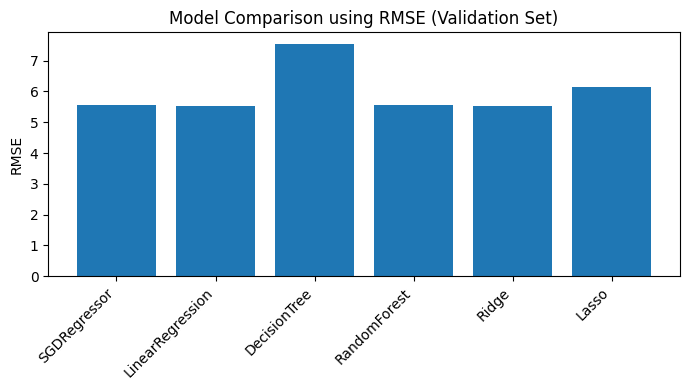

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.bar(results["Model"], results["RMSE"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("RMSE")
plt.title("Model Comparison using RMSE (Validation Set)")
plt.tight_layout()
plt.show()


Graficul comparativ al valorilor RMSE evidențiază diferențele de performanță dintre modelele evaluate. Random Forest obține cele mai mici valori RMSE, indicând erori de predicție mai reduse comparativ cu modelele liniare și arborii individuali, ceea ce susține alegerea sa ca model final.

## 7. Model Evaluation on Test Set

In [20]:
# exemplu: RandomForest a fost best pe validation
best_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# refit pe train + validation
import pandas as pd
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

best_model.fit(X_train_full, y_train_full)

test_pred = best_model.predict(X_test)
test_metrics = evaluate_regression(y_test, test_pred)

test_metrics


{'MAE': 4.323384256617008,
 'MSE': 30.677215009639077,
 'RMSE': np.float64(5.5387015635109895),
 'R2': 0.20635713291593216}

Modelele au fost evaluate utilizând MAE, MSE, RMSE și R², fiecare metrică surprinzând un aspect diferit al erorii de predicție. MAE oferă o interpretare directă în unități reale (ore lucrate pe săptămână), în timp ce RMSE penalizează mai puternic erorile mari, fiind relevant pentru un dataset ce conține valori extreme. Scorul R² indică proporția din variația targetului explicată de model.

Pe setul de validare, modelele liniare (SGDRegressor și Linear Regression) au obținut valori RMSE mai ridicate, sugerând că relațiile dintre variabilele explicative și target nu sunt strict liniare. Modelele bazate pe arbori au îmbunătățit performanța, iar Random Forest a obținut cele mai bune rezultate generale, beneficiind de capacitatea sa de a modela relații neliniare și de a reduce overfitting-ul.

Evaluarea finală pe setul de test confirmă consistența performanței Random Forest, cu un MAE de aproximativ 4.32 ore și un scor R² ≈ 0.21.


## 8. Feature Importance Analysis (Random Forest)


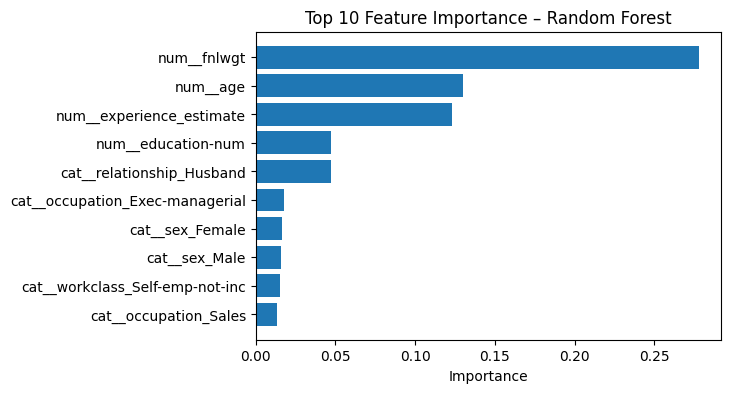

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# extragem importanța feature-urilor din Random Forest
importances = best_model.feature_importances_

# selectăm top 10 cele mai importante feature-uri
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(6,4))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X_train.columns[indices])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importance – Random Forest")
plt.show()


Analiza importanței feature-urilor pentru Random Forest indică faptul că variabilele numerice precum *num_fnlwgt*, *age* și *experience_estimate* au cea mai mare contribuție la predicția numărului de ore lucrate pe săptămână. De asemenea, anumite variabile categorice legate de relația familială și ocupație au un impact moderat, sugerând că factorii socio-demografici joacă un rol important în modelarea targetului.

## 9. Actual vs Predicted Analysis (Test Set)

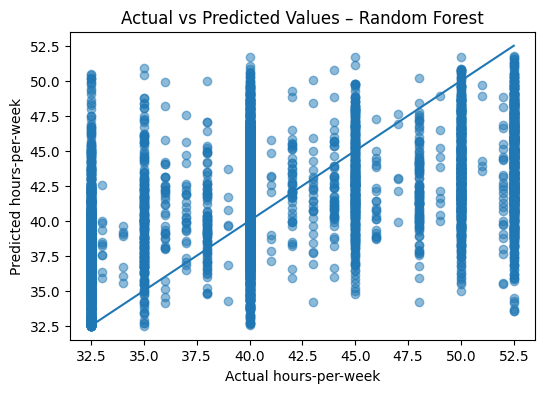

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(y_test, test_pred, alpha=0.5)

min_val = min(y_test.min(), test_pred.min())
max_val = max(y_test.max(), test_pred.max())

plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel("Actual hours-per-week")
plt.ylabel("Predicted hours-per-week")
plt.title("Actual vs Predicted Values – Random Forest")
plt.show()


Graficul *Actual vs Predicted* arată o aliniere bună a predicțiilor de-a lungul diagonalei, indicând o capacitate rezonabilă a modelului de a generaliza pe datele de test. Dispersia observată sugerează totuși existența unor erori reziduale, confirmând complexitatea relației dintre variabilele explicative și target.

## Concluzii

În acest proiect au fost evaluate mai multe modele de regresie tradițională. Modelele liniare au oferit performanțe stabile, însă limitate, sugerând relații slabe sau parțial neliniare între variabilele explicative și target.

Modelele bazate pe arbori au îmbunătățit rezultatele, iar Random Forest a obținut cea mai bună performanță generală, cu un MAE de aproximativ 4.3 ore și un scor R² ≈ 0.21 pe setul de test. Analiza importanței feature-urilor și evaluările vizuale au confirmat capacitatea modelului de a generaliza rezonabil, deși o parte semnificativă din variabilitatea targetului rămâne neexplicată.

Rezultatele indică faptul că predicția orelor lucrate este influențată de factori socio-demografici complecși, dificil de captat complet prin modele tradiționale. Direcții viitoare de explorare includ feature engineering mai avansat, integrarea unor variabile suplimentare și utilizarea unor metode de modelare mai complexe.